In [1]:
import iris
import numpy as np
import cv2
from iris import quickplot as qplt
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from mogreps_utils import list_files, get_uk_global_pairs

In [3]:
# !!mkdir /usr/local/share/notebooks/data/mogreps-gg
# !s3fs mogreps-g /usr/local/share/notebooks/data/mogreps-gg -o endpoint=eu-west-2 -o public_bucket=1

In [4]:
# !!mkdir /usr/local/share/notebooks/data/mogreps-uk
# !s3fs mogreps-uk /usr/local/share/notebooks/data/mogreps-uk -o endpoint=eu-west-2 -o public_bucket=1

In [5]:
def get_diff(uk_cube, g_cube):
    diff = g_cube - uk_cube
    
    try:
        diff.add_aux_coord(uk_cube.coord('time'))
        diff.coord('time').var_name = 'time'
    except ValueError: 
        pass
    
    return diff

In [6]:
def get_loss(uk_cube, g_cube):
    diff = get_diff(uk_cube, g_cube)
    hr_loss = diff.collapsed(['latitude', 'longitude'], iris.analysis.RMS).data.item(0)
    return hr_loss

In [11]:
def get_flow_diff(uk_cube, g_cube):
    flow = cv2.calcOpticalFlowFarneback(uk_cube.data,g_cube.data, None, 0.5, 0, 15, 30, 1, 0.5, 0)
    
#     hsv = np.zeros(uk_cube.data.shape + (3,))
#     hsv[...,1] = 255

#     mag, ang = cv2.cartToPolar(flow[:,:,0], flow[:,:,1])
#     hsv[...,0] = ang*180/np.pi/2
#     hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    return flow

In [12]:
def get_flow_loss(uk_cube, g_cube):
    diff = get_flow_diff(uk_cube, g_cube)
    hr_loss = np.mean(np.abs(diff[:,:,0]))
    return hr_loss

In [13]:
def draw_flow(img, flow, step=16):
    h, w = img.shape[:2]
    y, x = np.mgrid[step//2:h:step, step//2:w:step].reshape(2,-1)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (1, 0, 0), 1)
    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 0, 1), -1)
    return vis

In [14]:
g_files = list_files('mogreps-g', 'prods_op_mogreps-g_20160207_00_01', 10000)
uk_files = list_files('mogreps-uk', 'prods_op_mogreps-uk_20160207_03_01', 10000)

In [44]:
variable = 'relative_humidity'

In [ ]:
%%time 
uks, gs = get_uk_global_pairs(variable, uk_files, g_files)

/opt/conda/lib/python3.5/site-packages/iris/fileformats/cf.py:1140: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


DimCoord([2016-02-07 06:00:00], standard_name='time', calendar='gregorian', var_name='time_2')
DimCoord([2016-02-07 09:00:00], standard_name='time', calendar='gregorian', var_name='time_0')
DimCoord([2016-02-07 12:00:00], standard_name='time', calendar='gregorian', var_name='time_0')
DimCoord([2016-02-07 15:00:00], standard_name='time', calendar='gregorian', var_name='time_0')
DimCoord([2016-02-07 18:00:00], standard_name='time', calendar='gregorian', var_name='time_0')
DimCoord([2016-02-07 21:00:00], standard_name='time', calendar='gregorian', var_name='time_0')
DimCoord([2016-02-08 00:00:00], standard_name='time', calendar='gregorian', var_name='time_0')
DimCoord([2016-02-08 03:00:00], standard_name='time', calendar='gregorian', var_name='time_0')
DimCoord([2016-02-08 06:00:00], standard_name='time', calendar='gregorian', var_name='time_0')
DimCoord([2016-02-08 09:00:00], standard_name='time', calendar='gregorian', var_name='time_0')
DimCoord([2016-02-08 12:00:00], standard_name='tim

In [ ]:
scheme=iris.analysis.Nearest()

uks_regrid = [uks[i].regrid(grid=gs[i], scheme=scheme) for i in range(len(uks))]
gs_regrid = [gs[i].regrid(grid=uks[i], scheme=scheme) for i in range(len(uks))]

In [ ]:
diffs_hr = iris.cube.CubeList([get_diff(uks[i], gs_regrid[i]) for i in range(len(uks))]).merge_cube()
diffs_lr = iris.cube.CubeList([get_diff(uks_regrid[i], gs[i]) for i in range(len(uks))]).merge_cube()

In [ ]:
flow_diffs_hr = [get_flow_diff(uks[i], gs_regrid[i]) for i in range(len(uks))]

In [ ]:
flow = cv2.calcOpticalFlowFarneback(uks[0].data, gs_regrid[0].data, None, 0.9, 20, 3, 100, 2, 0.5, 0)
np.max(flow[:,:,1])

In [ ]:
f = draw_flow(uks[0].data, flow = cv2.calcOpticalFlowFarneback(uks[0].data, gs_regrid[0].data, None, 0.9, 10, 3, 100, 2, 0.5, 0))


In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(f)

/opt/conda/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/conda/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


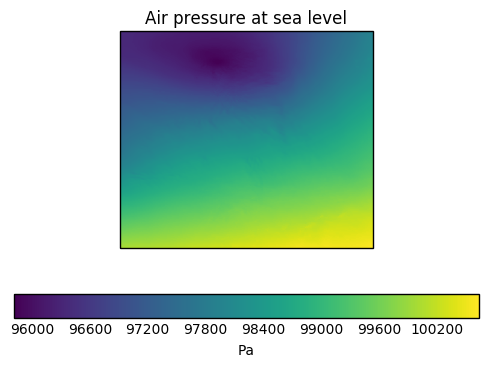

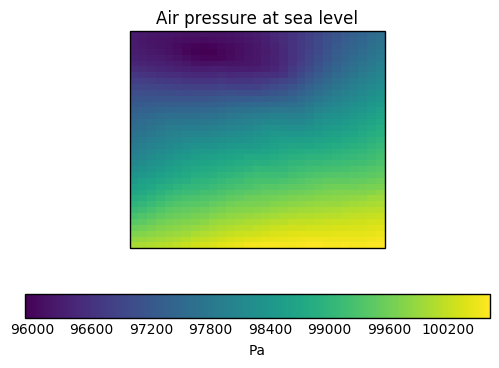

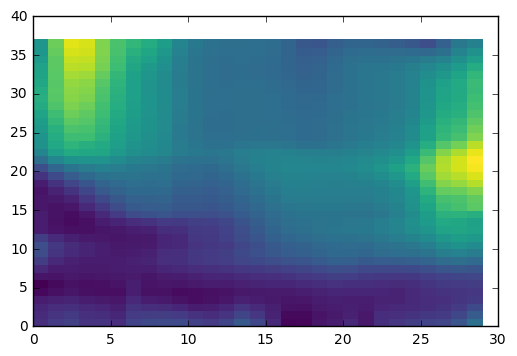

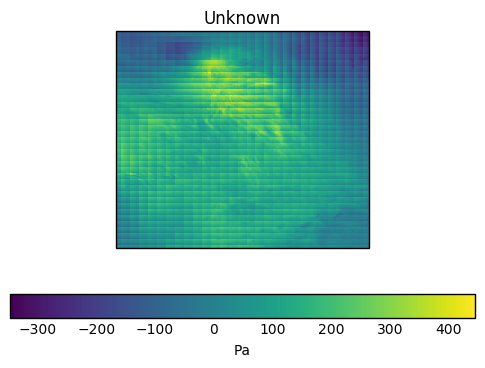

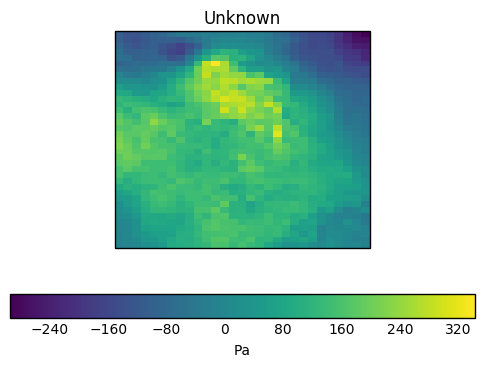

In [157]:
i = 2

qplt.pcolormesh(uks[i], cmap='viridis')
qplt.show()
qplt.pcolormesh(gs[i], cmap='viridis')
qplt.show()
plt.pcolormesh(flow_diffs_hr[i], cmap='viridis')
plt.show()
qplt.pcolormesh(diffs_hr[i], cmap='viridis')
qplt.show()
qplt.pcolormesh(diffs_lr[i], cmap='viridis')
qplt.show()

In [158]:
hr_loss = np.array([pd.collapsed(['latitude', 'longitude'], iris.analysis.RMS).data.item(0) for pd in diffs_hr.slices_over('time')])

/opt/conda/lib/python3.5/site-packages/iris/cube.py:3254: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/conda/lib/python3.5/site-packages/iris/coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/opt/conda/lib/python3.5/site-packages/iris/coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


In [159]:
lr_loss = np.array([pd.collapsed(['latitude', 'longitude'], iris.analysis.RMS).data.item(0) for pd in diffs_lr.slices_over('time')])

/opt/conda/lib/python3.5/site-packages/iris/cube.py:3254: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/conda/lib/python3.5/site-packages/iris/coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/opt/conda/lib/python3.5/site-packages/iris/coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


In [160]:
2*(hr_loss - lr_loss)/(hr_loss + lr_loss)

array([ 0.03600442,  0.05024465,  0.04337425,  0.04693489,  0.06664738,
        0.06270126,  0.05119294,  0.06259195,  0.07765078,  0.06230258,
        0.05350365,  0.06733132])

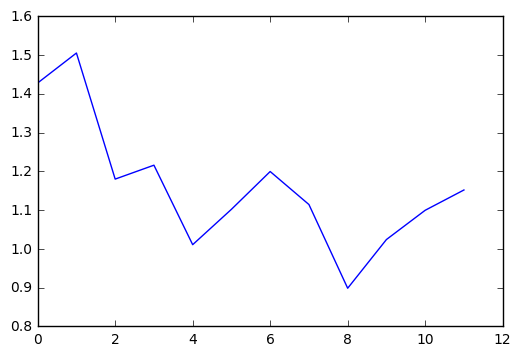

In [161]:
plt.plot([np.mean(np.abs(mag)) for mag in flow_diffs_hr])

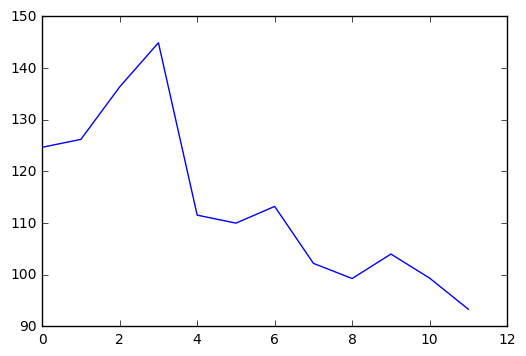

In [162]:
plt.plot(hr_loss)

In [163]:
hr_diff_grid = [[get_loss(uk1, uk2) for uk1 in uks] for uk2 in uks]
hr_diff_grid = np.array(hr_diff_grid)
hr_diff_grid_s = (hr_diff_grid - np.min(hr_diff_grid))
hr_diff_grid_s = hr_diff_grid_s / np.max(hr_diff_grid_s)

/opt/conda/lib/python3.5/site-packages/iris/cube.py:3254: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/conda/lib/python3.5/site-packages/iris/coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/opt/conda/lib/python3.5/site-packages/iris/coords.py:992: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


In [164]:
flow_diff_grid = [[get_flow_loss(g1, g2) for g1 in gs] for g2 in gs]
flow_diff_grid = np.array(flow_diff_grid)
flow_diff_grid_s = (flow_diff_grid - np.min(flow_diff_grid))
flow_diff_grid_s = flow_diff_grid_s / np.max(flow_diff_grid_s)

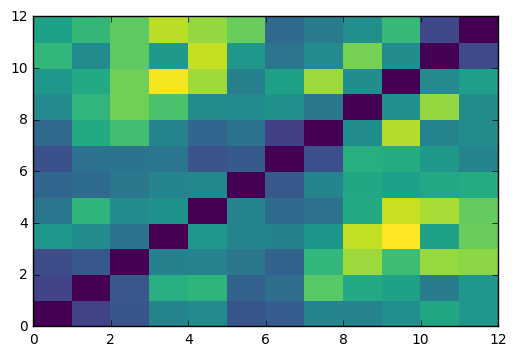

In [165]:
plt.pcolormesh(flow_diff_grid_s, cmap='viridis')

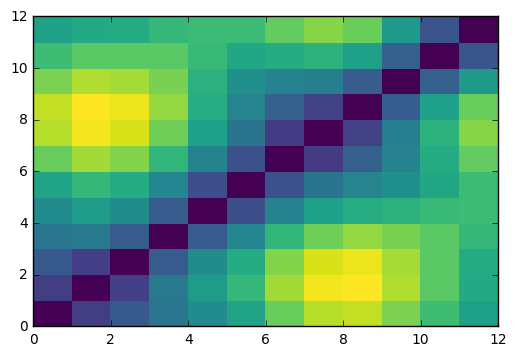

In [166]:
plt.pcolormesh(hr_diff_grid_s, cmap='viridis')

/opt/conda/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/conda/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


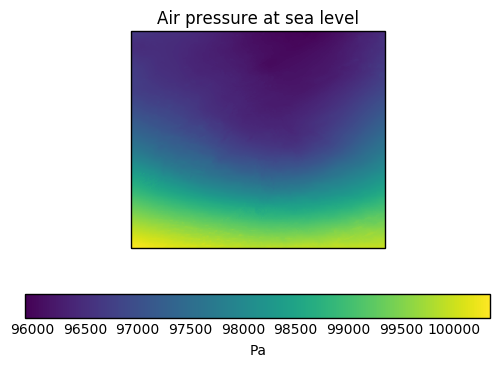

In [171]:
qplt.pcolormesh(uks[9], cmap='viridis')

/opt/conda/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/conda/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


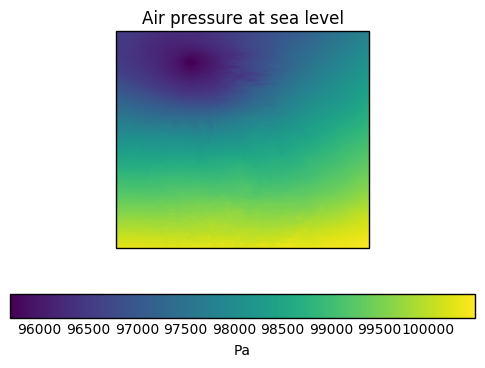

In [173]:
qplt.pcolormesh(uks[1], cmap='viridis')

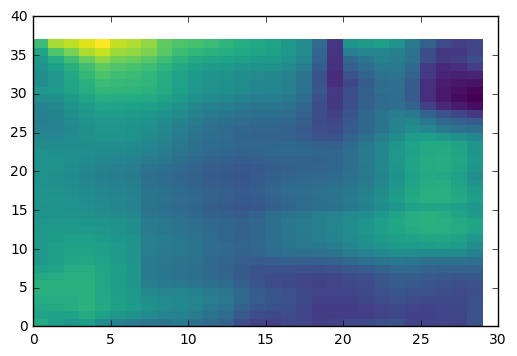

In [174]:
plt.pcolormesh(flow_diffs_hr[7], cmap='viridis')

/opt/conda/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/conda/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


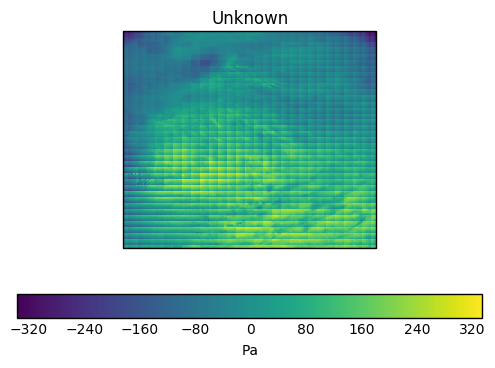

In [175]:
qplt.pcolormesh(diffs_hr[7], cmap='viridis')